Importing required libraries 


In [ ]:
#Import required libraries

import warnings
warnings.filterwarnings('ignore')

import keras
import keras.backend as K
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
# from tensorflow.python.keras.models import Sequential
# from tensorflow.python.keras.layers import Dense, LSTM, Dropout,Activation
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Bidirectional
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
%matplotlib inline

Loading train, test and rul csv files as dataframes to be processed

In [ ]:
train_3= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/train_FD003.txt" ,sep=" ",header=None)
train_3.drop(columns=[26,27],inplace=True)

In [ ]:
test_3= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/test_FD003.txt",sep=" ",header=None)
test_3.drop(columns=[26,27],inplace=True)

In [ ]:
rul_3= pd.read_csv("/content/drive/MyDrive/CAPSTONE CODES WEISHENG/CMAPSSData/RUL_FD003.txt",sep=" ",header=None)
rul_3.drop(columns=[1],inplace=True)

Changing Features name to s1-s21

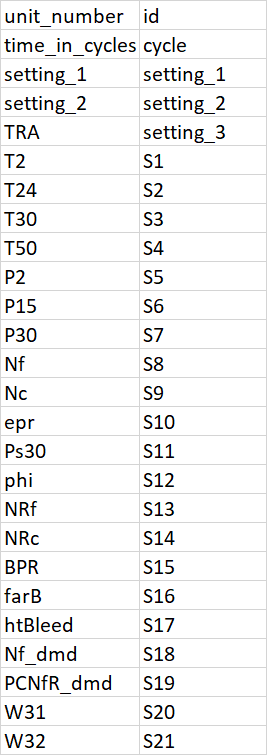


In [ ]:
columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#            'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]                     

In [ ]:
train_3.columns = columns
test_3.columns = columns

In [ ]:
description = train_3.describe()
description.loc['std']

id          2.934899e+01
cycle       9.884668e+01
setting1    2.193545e-03
setting2    2.940429e-04
setting3    0.000000e+00
s1          6.684921e-11
s2          5.230311e-01
s3          6.810418e+00
s4          9.773178e+00
s5          3.602525e-12
s6          1.811600e-02
s7          3.437343e+00
s8          1.582849e-01
s9          1.998029e+01
s10         3.484849e-03
s11         3.000742e-01
s12         3.255314e+00
s13         1.581207e-01
s14         1.650412e+01
s15         6.051161e-02
s16         1.750371e-14
s17         1.761459e+00
s18         0.000000e+00
s19         0.000000e+00
s20         2.488647e-01
s21         1.492338e-01
Name: std, dtype: float64

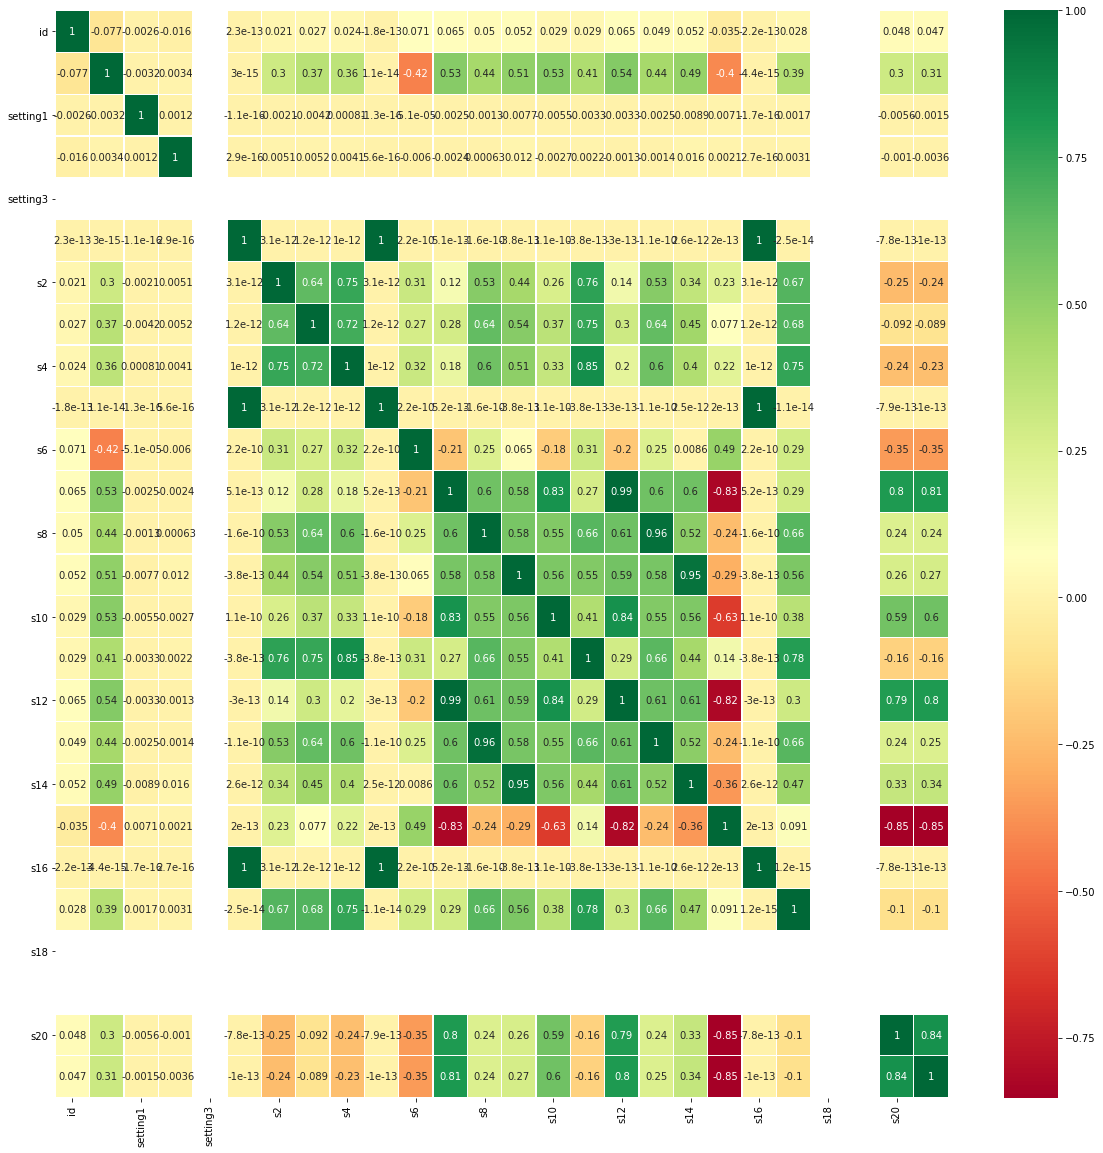

In [ ]:
sns.heatmap(train_3.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [ ]:
#delete columns with constant values that do not carry information about the state of the unit
# train_3.drop(columns=['s16', 's19','s18','s5','s1','setting3','setting1','setting2'],inplace=True)

In [ ]:
description = train_3.describe()
description.loc['std']

id          2.934899e+01
cycle       9.884668e+01
setting1    2.193545e-03
setting2    2.940429e-04
setting3    0.000000e+00
s1          6.684921e-11
s2          5.230311e-01
s3          6.810418e+00
s4          9.773178e+00
s5          3.602525e-12
s6          1.811600e-02
s7          3.437343e+00
s8          1.582849e-01
s9          1.998029e+01
s10         3.484849e-03
s11         3.000742e-01
s12         3.255314e+00
s13         1.581207e-01
s14         1.650412e+01
s15         6.051161e-02
s16         1.750371e-14
s17         1.761459e+00
s18         0.000000e+00
s19         0.000000e+00
s20         2.488647e-01
s21         1.492338e-01
Name: std, dtype: float64

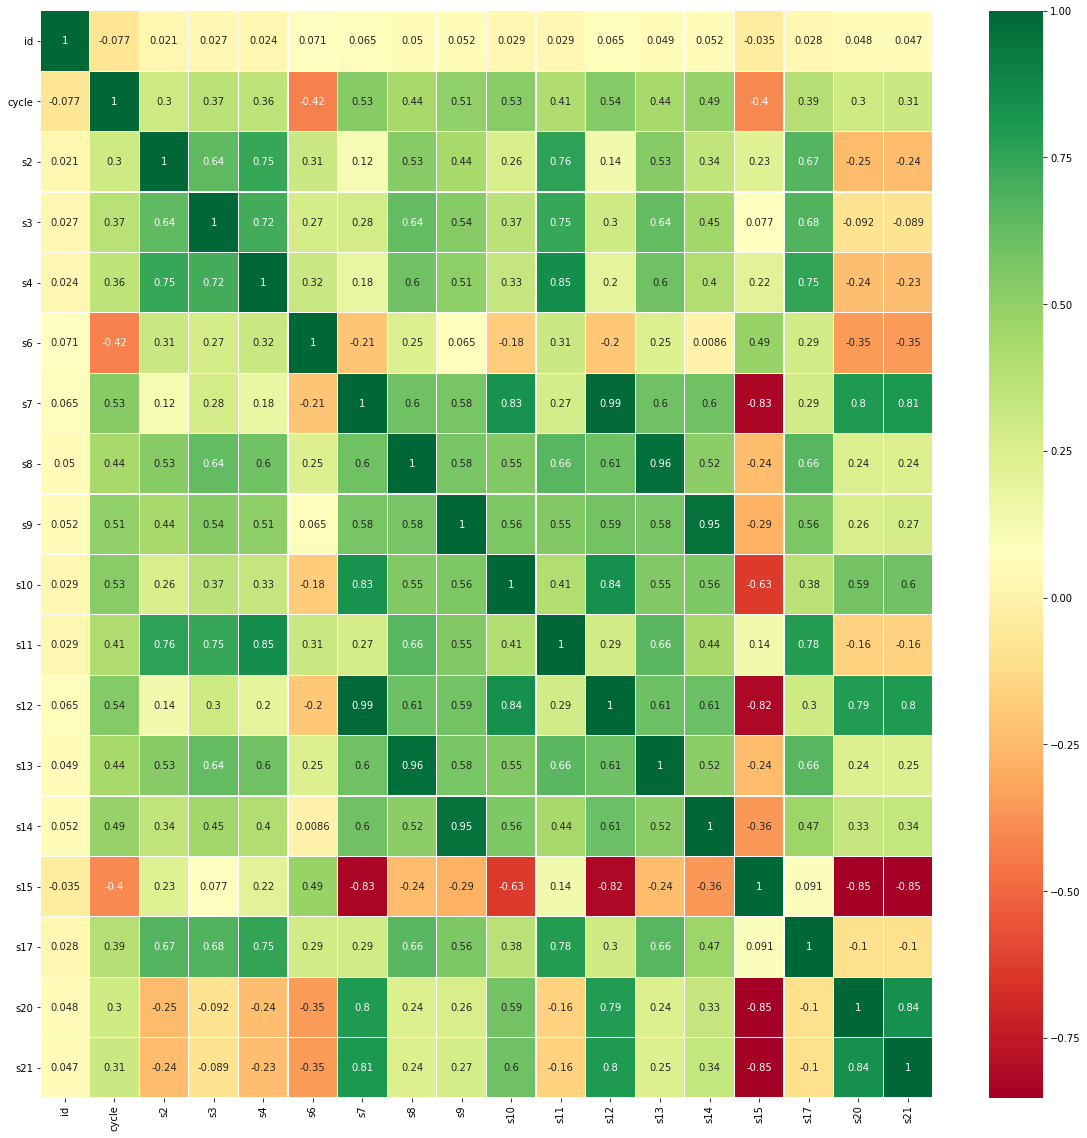

In [ ]:
sns.heatmap(train_3.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [ ]:
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('id')['cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['id','max']
    df = df.merge(fd_RUL, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop(columns=['max'],inplace = True)
    return df[df['cycle'] > factor]
train_3 = prepare_train_data(train_3)    

Preprocessing for LSTM


In [ ]:
# MinMax normalization (from 0 to 1) train set
train_3['cycle_norm'] = train_3['cycle']
cols_normalize = train_3.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_3 = pd.DataFrame(min_max_scaler.fit_transform(train_3[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_3.index)
join_df = train_3[train_3.columns.difference(cols_normalize)].join(norm_train_3)
train_3 = join_df.reindex(columns = train_3.columns)

# MinMax normalization (from 0 to 1) test set
test_3['cycle_norm'] = test_3['cycle']
norm_test_3 = pd.DataFrame(min_max_scaler.transform(test_3[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_3.index)
test_join_df = test_3[test_3.columns.difference(cols_normalize)].join(norm_test_3)
test_3 = test_join_df.reindex(columns = test_3.columns)
test_3 = test_3.reset_index(drop=True)
print(test_3.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_3.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul_3.columns = ['more']
rul_3['id'] = rul_3.index + 1
rul_3['max'] = rul['max'] + rul_3['more']
rul_3.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_3 = test_3.merge(rul_3, on=['id'], how='left')
test_3['RUL'] = test_3['max'] - test_3['cycle']
test_3.drop('max', axis=1, inplace=True)

   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.401163  0.153846  ...  0.0  0.535714  0.532702    0.000000
1   1      2  0.534884  0.307692  ...  0.0  0.517857  0.564153    0.001908
2   1      3  0.581395  0.230769  ...  0.0  0.553571  0.511921    0.003817
3   1      4  0.656977  0.538462  ...  0.0  0.476190  0.561833    0.005725
4   1      5  0.494186  0.538462  ...  0.0  0.547619  0.484646    0.007634

[5 rows x 27 columns]


In [ ]:
sequence_length = 50

In [ ]:
train_3.columns

Index(['id', 'cycle', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's10', 's11',
       's12', 's13', 's14', 's15', 's17', 's20', 's21', 'RUL', 'cycle_norm'],
      dtype='object')

In [ ]:
# preparing data for visualizations 
# window of 50 cycles prior to a failure point for engine id 3
engine_id3 = test_3[test_3['id'] == 3]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ['s2', 's3', 's4', 's6', 's7', 's8', 's9', 's10', 's11',
       's12', 's13', 's14', 's15', 's17', 's20', 's21']
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[cols1]


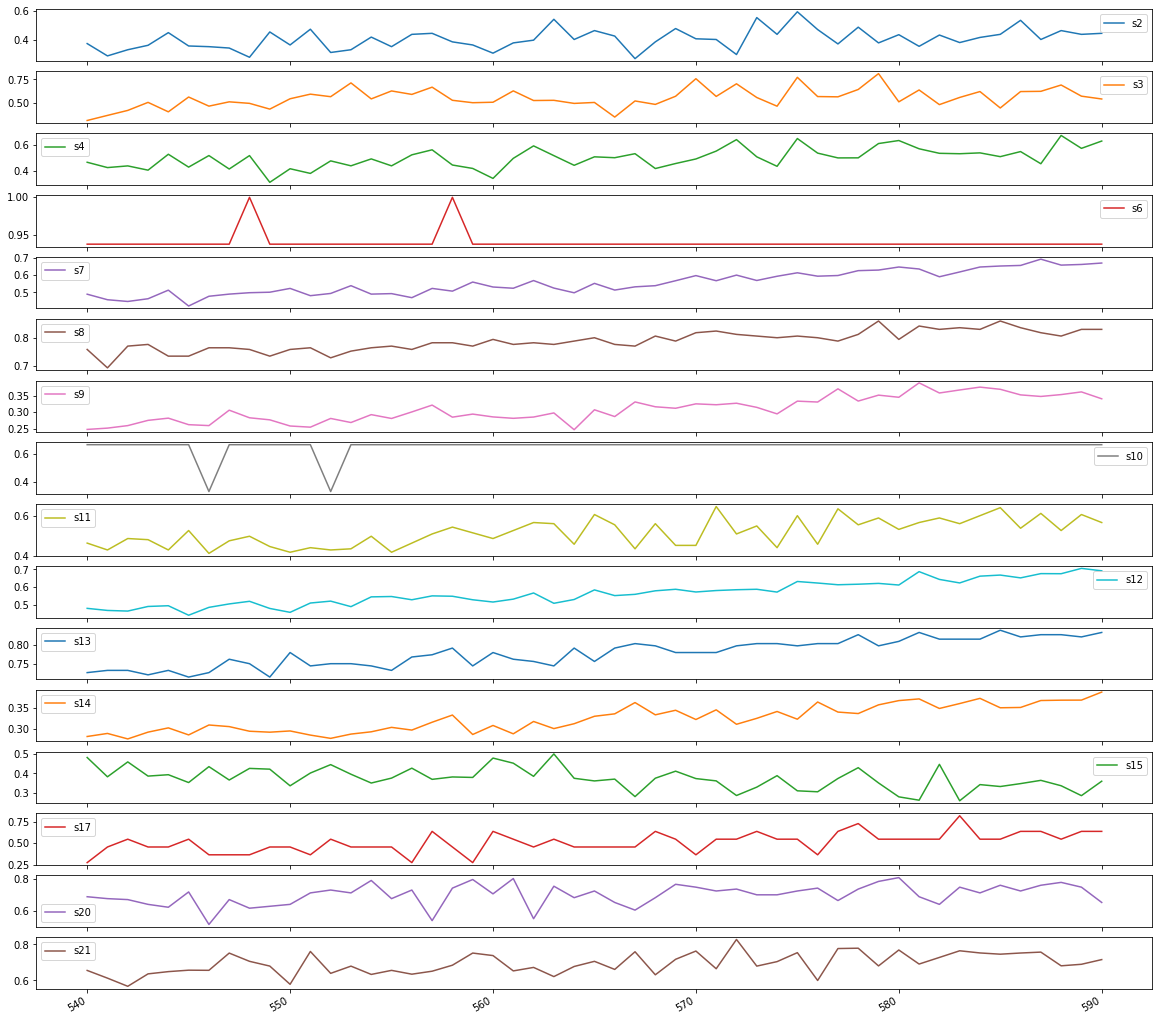

In [ ]:
# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(20,20))

In [ ]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [ ]:
# pick the feature columns 
# sequence_cols = ['cycle_norm','s2', 's3', 's4', 's6', 's7', 's8', 's9', 's10', 's11',
#        's12', 's13', 's14', 's15', 's17', 's20', 's21']

#without removing features
sequence_cols = ['setting1', 'setting2', 'setting3', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
       's15', 's16', 's17', 's18', 's19', 's20', 's21', 'cycle_norm']

seq_gen = (list(gen_sequence(train_3[train_3['id']==id], sequence_length, sequence_cols)) 
           for id in train_3['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(19720, 50, 25)

In [ ]:
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [ ]:
# generate labels
label_gen = [gen_labels(train_3[train_3['id']==id], sequence_length, ['RUL']) 
             for id in train_3['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(19720, 1)

In [ ]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
seq_array_test_last = [test_3[test_3['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_3['id'].unique() if len(test_3[test_3['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(97, 50, 25)

In [ ]:
y_mask = [len(test_3[test_3['id']==id]) >= sequence_length for id in test_3['id'].unique()]
label_array_test_last = test_3.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

LSTM, BASE MODEL


In [ ]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm_model = Sequential()

lstm_model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=50,
         return_sequences=True))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(
          units=20,
          return_sequences=False))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(units=nb_out, activation='linear'))
lstm_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse',r2_keras])

lstm_model.summary()

# optimizer='rmsprop'

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            13600     
_________________________________________________________________
dropout (Dropout)            (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 19,301
Trainable params: 19,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# # define path to save model

# bst_model_path = 'lstm_dataset2' + '.h5'
# model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

In [ ]:
lstm_model.save('lstm_model_rmsprop_50_20_data3.h5')

In [ ]:
%%time
# fit the network
fitting = lstm_model.fit(seq_array, label_array, epochs=300, batch_size=10, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min')])
fitting

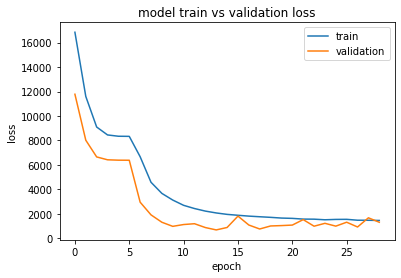

In [ ]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
# training metrics
scores = lstm_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

99/99 [==============================] - 1s 5ms/step - loss: 1173.2754 - mse: 1173.2754 - r2_keras: 0.6462

MSE: 1173.275390625

R^2: 0.6461793184280396
RMSE: 34.253108


In [ ]:
seq_array_test_last = [test_3[test_3['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_3['id'].unique() if len(test_3[test_3['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(97, 50, 25)

In [ ]:
y_mask = [len(test_3[test_3['id']==id]) >= sequence_length for id in test_3['id'].unique()]
label_array_test_last = test_3.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [ ]:
scores_test = lstm_model.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

1/1 [==============================] - 0s 20ms/step - loss: 906.1338 - mse: 906.1338 - r2_keras: 0.4487

MSE: 906.1337890625

R^2: 0.44874703884124756
RMSE: 30.102056


In [ ]:
seq_array_test_last.shape

(97, 50, 17)

In [ ]:
## Use XGBoost 
import xgboost as xgb
import matplotlib.pyplot as plt  
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

# Initialize Model
xgb_model = xgb.XGBRegressor(colsample_bytree = 0.5, learning_rate = 0.5,
                max_depth = 6, alpha = 10, n_estimators = 150)

# Train Test Split
X_train = seq_array.reshape(19720, 850)
y_train = label_array
X_test = seq_array_test_last.reshape(97, 850)
y_test = label_array_test_last

# Model Fitting on Data
xgb_model.fit(X_train, y_train)

# Get Predictions
y_pred = xgb_model.predict(X_test)

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))


[06:31:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 38.814198


In [ ]:
# from sklearn.metrics import mean_squared_error
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# print("RMSE: %f" % (rmse))

RMSE: 39.802929


In [ ]:
# X_test = xgb_model.predict(seq_array_test_last.reshape(97, 850))
# rmse = np.sqrt(mean_squared_error(X_test, label_array_test_last))
# print("RMSE: %f" % (rmse))

RMSE: 30.512495


MLP

In [ ]:
# mlp for Regression
from pandas import read_csv
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from numpy import sqrt

In [ ]:
# define model
mlp_model = Sequential()
mlp_model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_shape=(nb_features * 50,)))
mlp_model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(4, activation='relu', kernel_initializer='he_normal'))
mlp_model.add(Dense(1))
print(mlp_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                54464     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 5         
Total params: 57,249
Trainable params: 57,249
Non-trainable params: 0
__________________________________________________

In [ ]:
# compile the model
mlp_model.compile(optimizer='rmsprop', loss='mse', metrics=['mse',r2_keras])

In [ ]:
# fit the model
mlp_model.fit(seq_array.reshape(19720, 850), label_array, epochs=300, batch_size=32, validation_split=0.2, verbose=1,
              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='auto')])

In [ ]:
# training metrics
scores = mlp_model.evaluate(seq_array.reshape(19720, 850), label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

99/99 [==============================] - 0s 3ms/step - loss: 918.0895 - mse: 918.0895 - r2_keras: 0.7320

MSE: 918.0895385742188

R^2: 0.73196941614151
RMSE: 30.299992


In [ ]:
# test metrics
scores_test = mlp_model.evaluate(seq_array_test_last.reshape(97, 850), label_array_test_last, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

1/1 [==============================] - 0s 21ms/step - loss: 499.1632 - mse: 499.1632 - r2_keras: 0.6963

MSE: 499.1631774902344

R^2: 0.6963305473327637
RMSE: 22.341960


State of Art Method https://github.com/verenich/ProcessSequencePrediction/blob/master/code/train.py

In [ ]:
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Input
from keras.utils.data_utils import get_file
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from collections import Counter
import numpy as np
import random
import sys
import os
import copy
import csv
import time
from datetime import datetime
from math import log

Activation Function


In [ ]:
# https://www.bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
from keras.backend import sigmoid
import tensorflow as tf

def swish(x, beta = 1.5):
    return (x * K.sigmoid(beta * x))

def myleakyrelu(x,a=0.01):
    cond = tf.less(x, tf.constant(0))
    return tf.where(cond, a*x, x)

def lrelu001(x,a=0.01):
   return K.maximum(x,a*x)

def lrelu025(x,a=0.25):
   return K.maximum(x,a*x)

def tanh(x):
    return K.tanh(x)

def penalized_tanh(x):
    alpha = 0.25
    return K.maximum(tanh(x), alpha*tanh(x))

# def cube(x):
#     return K.pow(x,3)    

# def sin(x):
#     return K.sin(x)

# def maxsig(x):
#     return K.maximum(x, K.sigmoid(x))

# def cosper(x):
#     return (K.cos(x) -x)

# def minsin(x):
#     return K.minimum(x, K.sin(x))

# def tanhrev(x):
#     return  (K.pow(K.cos(x)/K.sin(x),2) -x)


# def maxtanh(x):
#     return K.maximum(x, K.tanh(x))


In [ ]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Bidirectional
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout,Activation
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': swish})
get_custom_objects().update({'myleakyrelu': myleakyrelu})
get_custom_objects().update({'lrelu001': lrelu001})
get_custom_objects().update({'lrelu025': lrelu025})
get_custom_objects().update({'penalized_tanh': penalized_tanh})
# get_custom_objects().update({'sin': sin})
# get_custom_objects().update({'cube': cube})
# get_custom_objects().update({'tanhrev': tanhrev})
# get_custom_objects().update({'maxtanh': maxtanh})


In [ ]:
from keras.layers import Bidirectional
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout,Activation

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(sequence_length, nb_features)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(LSTM(50, return_sequences=False, activation = 'tanh'))
bilstm_model.add(Dropout(0.2))

bilstm_model.add(Dense(units=nb_out))
bilstm_model.add(Activation("linear"))
bilstm_model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(bilstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 50, 40)            6080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 24,331
Trainable params: 24,331
Non-trainable params: 0
__________________________________________________

In [ ]:
from keras.layers import Bidirectional
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout,Activation

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

bilstm_model = Sequential(custom_objects={'swish':swish})
# bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(sequence_length, nb_features)))
bilstm_model.add(Dropout(0.2))

# bilstm_model.add(Activation("swish"))
bilstm_model.add(BatchNormalization())
# bilstm_model.add(Activation("swish"))

bilstm_model.add(Bidirectional(LSTM(50, return_sequences=False)))
# bilstm_model.add(Dropout(0.2))
# bilstm_model.add(Bidirectional(LSTM(50, activation ="swish", return_sequences=False)))
# bilstm_model.add(Activation("swish"))


# Dense Layer
bilstm_model.add(Dense(units=nb_out))
bilstm_model.add(Activation("linear"))
bilstm_model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(bilstm_model.summary())

In [ ]:
# fit the network
%%time
fitting = bilstm_model.fit(seq_array, label_array, epochs=5, batch_size=10, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')])
fitting

Epoch 1/5
1874/1874 - 861s - loss: 13077.5488 - mse: 13077.5488 - r2_keras: -8.5710e-01 - val_loss: 7148.6860 - val_mse: 7148.6860 - val_r2_keras: -8.2950e+02
Epoch 2/5
1874/1874 - 867s - loss: 8390.1689 - mse: 8390.1689 - r2_keras: -1.6604e-01 - val_loss: 6378.5972 - val_mse: 6378.5972 - val_r2_keras: -7.4664e+02
Epoch 3/5
1874/1874 - 862s - loss: 5596.8286 - mse: 5596.8286 - r2_keras: 0.2715 - val_loss: 2071.7480 - val_mse: 2071.7480 - val_r2_keras: -2.4005e+02
Epoch 4/5
1874/1874 - 857s - loss: 3294.5312 - mse: 3294.5312 - r2_keras: 0.5591 - val_loss: 1903.8323 - val_mse: 1903.8323 - val_r2_keras: -2.2607e+02
Epoch 5/5
1874/1874 - 858s - loss: 2666.0520 - mse: 2666.0520 - r2_keras: 0.6172 - val_loss: 972.0042 - val_mse: 972.0042 - val_r2_keras: -1.1364e+02
CPU times: user 1h 49min 46s, sys: 15min 8s, total: 2h 4min 54s
Wall time: 1h 11min 45s


In [ ]:
bilstm_model.save('bilstm_model_rmsprop_50_20.h5')

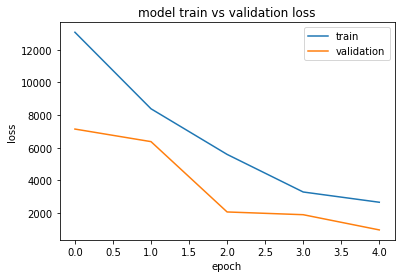

In [ ]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
# training metrics
scores = bilstm_model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

99/99 [==============================] - 4s 39ms/step - loss: 2389.5251 - mse: 2389.5251 - r2_keras: 0.1967

MSE: 2389.525146484375

R^2: 0.1967499703168869
RMSE: 48.882769


In [ ]:
seq_array_test_last = [test_3[test_3['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_3['id'].unique() if len(test_3[test_3['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(97, 50, 17)

In [ ]:
y_mask = [len(test_3[test_3['id']==id]) >= sequence_length for id in test_3['id'].unique()]
label_array_test_last = test_3.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

In [ ]:
scores_test = bilstm_model.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

1/1 [==============================] - 0s 58ms/step - loss: 2182.2993 - mse: 2182.2993 - r2_keras: -0.3276

MSE: 2182.29931640625

R^2: -0.3276174068450928
RMSE: 46.715087


In [ ]:
def plot_result(y_true,y_pred):
    rcParams['figure.figsize'] = 12,10
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('training samples')
    plt.legend(('Predicted', 'True'), loc='upper right')
    plt.title('COMPARISION OF Real and Predicted values')
    plt.show()
    return
plot_result(y_true,y_pred)    

Speed without losing rmse


In [ ]:
l2_2 = LSTM(100, implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, dropout=0.2)(b1) # the layer specialized in time prediction

x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)

x = Bidirectional(GRU(units, return_sequences = True))(x)
x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)

kernel_initializer = "he_uniform"
kernel_initializer = "he_normal"

In [ ]:
from keras.layers import Bidirectional
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout,Activation

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

bilstm_speed = Sequential()
bilstm_speed.add(Bidirectional(LSTM(20, return_sequences=True, kernel_initializer='glorot_uniform', dropout=0.5,recurrent_dropout=0.5), input_shape=(sequence_length, nb_features)))
# bilstm_speed.add(Dropout(0.2))
bilstm_speed.add(BatchNormalization())
bilstm_speed.add(LSTM(50, return_sequences=False, kernel_initializer='glorot_uniform', dropout=0.5))
# bilstm_speed.add(Dropout(0.2))

bilstm_speed.add(Dense(units=nb_out))
bilstm_speed.add(Activation("linear"))
bilstm_speed.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(bilstm_speed.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 50, 40)            7360      
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 40)            160       
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 25,771
Trainable params: 25,691
Non-trainable params: 80
_________________________________________________________________
None


In [ ]:
# fit the network
%%time
fitting = bilstm_speed.fit(seq_array, label_array, epochs=100, batch_size=32, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')])
fitting

Epoch 1/100
586/586 - 516s - loss: 16834.1309 - mse: 16834.1309 - r2_keras: -1.1701e+00 - val_loss: 12296.2012 - val_mse: 12296.2012 - val_r2_keras: -1.3043e+02
Epoch 2/100
586/586 - 504s - loss: 12043.0928 - mse: 12043.0928 - r2_keras: -5.1391e-01 - val_loss: 8210.4775 - val_mse: 8210.4775 - val_r2_keras: -8.6499e+01
Epoch 3/100
586/586 - 504s - loss: 8624.2939 - mse: 8624.2939 - r2_keras: -6.8363e-02 - val_loss: 5438.9355 - val_mse: 5438.9355 - val_r2_keras: -5.6821e+01
Epoch 4/100
586/586 - 508s - loss: 6339.0029 - mse: 6339.0029 - r2_keras: 0.2265 - val_loss: 4428.7280 - val_mse: 4428.7280 - val_r2_keras: -4.6932e+01
Epoch 5/100
586/586 - 507s - loss: 4839.4219 - mse: 4839.4219 - r2_keras: 0.4157 - val_loss: 3241.6714 - val_mse: 3241.6714 - val_r2_keras: -3.4542e+01
Epoch 6/100
586/586 - 509s - loss: 3910.7737 - mse: 3910.7737 - r2_keras: 0.5248 - val_loss: 3122.4709 - val_mse: 3122.4709 - val_r2_keras: -3.4123e+01
Epoch 7/100
586/586 - 503s - loss: 3344.6604 - mse: 3344.6604 - r2_

In [ ]:
#Training metrics
scores = bilstm_speed.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))
#Test metrics
scores_test = bilstm_speed.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

99/99 [==============================] - 6s 57ms/step - loss: 1961.4932 - mse: 1961.4932 - r2_keras: 0.3624

MSE: 1961.4931640625

R^2: 0.36244598031044006
RMSE: 44.288748
1/1 [==============================] - 0s 71ms/step - loss: 1227.1077 - mse: 1227.1077 - r2_keras: 0.2535

MSE: 1227.107666015625

R^2: 0.2534802556037903
RMSE: 35.030097


In [ ]:
def plot_result(y_true,y_pred):
    rcParams['figure.figsize'] = 12,10
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('training samples')
    plt.legend(('Predicted', 'True'), loc='upper right')
    plt.title('COMPARISION OF Real and Predicted values')
    plt.show()
    return
plot_result(seq_array_test_last,label_array_test_last)    

Swish


In [ ]:
from keras.layers import Bidirectional
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout,Activation

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

bilstm_swish = Sequential()
bilstm_swish.add(Bidirectional(LSTM(20, return_sequences=True, kernel_initializer='glorot_uniform'), input_shape=(sequence_length, nb_features)))
bilstm_swish.add(Dropout(0.2))
bilstm_swish.add(BatchNormalization())
bilstm_swish.add(LSTM(50, return_sequences=False, activation = "swish"))
bilstm_swish.add(Dropout(0.2))

bilstm_swish.add(Dense(units=nb_out))
bilstm_swish.add(Activation("linear"))
bilstm_swish.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(bilstm_swish.summary())

In [ ]:
# fit the network
%%time
fitting = bilstm_swish.fit(seq_array, label_array, epochs=30, batch_size=32, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')])
fitting

Epoch 1/30
586/586 - 316s - loss: 36488144.0000 - mse: 36488144.0000 - r2_keras: -4.7606e+03 - val_loss: 79492.6406 - val_mse: 79492.6406 - val_r2_keras: -8.6212e+02
Epoch 2/30
586/586 - 310s - loss: 1092252288.0000 - mse: 1092252288.0000 - r2_keras: -1.2304e+05 - val_loss: 89301360.0000 - val_mse: 89301360.0000 - val_r2_keras: -8.4616e+05
Epoch 3/30
586/586 - 321s - loss: 6983379.5000 - mse: 6983379.5000 - r2_keras: -1.0353e+03 - val_loss: 19246.1953 - val_mse: 19246.1953 - val_r2_keras: -2.0565e+02
Epoch 4/30
586/586 - 315s - loss: 12486974.0000 - mse: 12486974.0000 - r2_keras: -2.3426e+03 - val_loss: 4475.6670 - val_mse: 4475.6670 - val_r2_keras: -4.8162e+01
Epoch 5/30
586/586 - 316s - loss: 31190.4883 - mse: 31190.4883 - r2_keras: -2.3517e+00 - val_loss: 5337.3145 - val_mse: 5337.3145 - val_r2_keras: -5.7195e+01
Epoch 6/30
586/586 - 314s - loss: 4392.4136 - mse: 4392.4136 - r2_keras: 0.4269 - val_loss: 5364.2720 - val_mse: 5364.2720 - val_r2_keras: -5.9246e+01
Epoch 7/30
586/586 - 

In [ ]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
# training metrics
scores = bilstm_swish.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

In [ ]:
scores_test = bilstm_swish.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

Penalized tahn


In [ ]:
from keras.layers import Bidirectional
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout,Activation

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

bilstm_penalized_tanh = Sequential()
bilstm_penalized_tanh.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(sequence_length, nb_features)))
bilstm_penalized_tanh.add(Dropout(0.2))
bilstm_penalized_tanh.add(BatchNormalization())
bilstm_penalized_tanh.add(LSTM(50, return_sequences=False, activation = "penalized_tanh"))
bilstm_penalized_tanh.add(Dropout(0.2))

bilstm_penalized_tanh.add(Dense(units=nb_out))
bilstm_penalized_tanh.add(Activation("linear"))
bilstm_penalized_tanh.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(bilstm_penalized_tanh.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 50, 40)            7360      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 40)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 25,611
Trainable params: 25,611
Non-trainable params: 0
__________________________________________________

In [ ]:
# fit the network
%%time
fitting = bilstm_penalized_tanh.fit(seq_array, label_array, epochs=30, batch_size=32, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')])
fitting

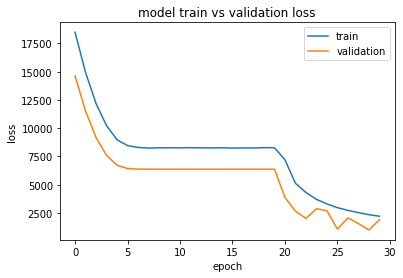

In [ ]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
# training metrics
scores = bilstm_penalized_tanh.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

99/99 [==============================] - 4s 45ms/step - loss: 2033.2471 - mse: 2033.2471 - r2_keras: 0.4042

MSE: 2033.2470703125

R^2: 0.40424108505249023
RMSE: 45.091541


In [ ]:
scores_test = bilstm_penalized_tanh.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))

1/1 [==============================] - 0s 52ms/step - loss: 989.7162 - mse: 989.7162 - r2_keras: 0.3979

MSE: 989.7162475585938

R^2: 0.3978990316390991
RMSE: 31.459756


tanhrev

In [ ]:
from keras.layers import Bidirectional
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout,Activation

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

bilstm_tanhrev = Sequential()
bilstm_tanhrev.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(sequence_length, nb_features)))
bilstm_tanhrev.add(Dropout(0.2))
bilstm_tanhrev.add(LSTM(50, return_sequences=False, activation = "tanhrev"))
bilstm_tanhrev.add(Dropout(0.2))

bilstm_tanhrev.add(Dense(units=nb_out))
bilstm_tanhrev.add(Activation("linear"))
bilstm_tanhrev.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mse',r2_keras])
print(bilstm_tanhrev.summary())

In [ ]:
# fit the network
%%time
fitting = bilstm_tanhrev.fit(seq_array, label_array, epochs=5, batch_size=10, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')])
fitting

Epoch 1/5
1874/1874 - 935s - loss: 184907385012224.0000 - mse: 184907385012224.0000 - r2_keras: -3.4822e+10 - val_loss: 233461301248.0000 - val_mse: 233461301248.0000 - val_r2_keras: -2.9346e+10
Epoch 2/5


In [ ]:
# plot train and validation loss
pyplot.plot(fitting.history['loss'])
pyplot.plot(fitting.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
# training metrics
scores = bilstm_tanhrev.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMSE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))
rmse = np.sqrt(scores[1])
print("RMSE: %f" % (rmse))

In [ ]:
scores_test = bilstm_tanhrev.evaluate(seq_array_test_last, label_array_test_last, verbose = 1, batch_size = 200)
print('\nMSE: ' + str(scores_test[1]))
print('\nR^2: {}'.format(scores_test[2]))
rmse = np.sqrt(scores_test[1])
print("RMSE: %f" % (rmse))